<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tay-tay-Text-Theatre" data-toc-modified-id="Tay-tay-Text-Theatre-1">Tay-tay Text Theatre</a></span><ul class="toc-item"><li><span><a href="#3-Questions-of-interest" data-toc-modified-id="3-Questions-of-interest-1.1">3 Questions of interest</a></span></li><li><span><a href="#Package-Imports" data-toc-modified-id="Package-Imports-1.2">Package Imports</a></span></li><li><span><a href="#The-dataset" data-toc-modified-id="The-dataset-1.3">The dataset</a></span><ul class="toc-item"><li><span><a href="#Context" data-toc-modified-id="Context-1.3.1">Context</a></span></li><li><span><a href="#Content" data-toc-modified-id="Content-1.3.2">Content</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-1.3.3">Data Cleaning</a></span></li></ul></li><li><span><a href="#Question-1:-Song-length?" data-toc-modified-id="Question-1:-Song-length?-1.4">Question 1: Song length?</a></span></li><li><span><a href="#Question-2:-Happiness?" data-toc-modified-id="Question-2:-Happiness?-1.5">Question 2: Happiness?</a></span><ul class="toc-item"><li><span><a href="#Per-Song" data-toc-modified-id="Per-Song-1.5.1">Per Song</a></span></li><li><span><a href="#Per-Album" data-toc-modified-id="Per-Album-1.5.2">Per Album</a></span></li></ul></li><li><span><a href="#Question-3:-Repetitiveness" data-toc-modified-id="Question-3:-Repetitiveness-1.6">Question 3: Repetitiveness</a></span><ul class="toc-item"><li><span><a href="#Measuring-repetitiveness?" data-toc-modified-id="Measuring-repetitiveness?-1.6.1">Measuring repetitiveness?</a></span></li><li><span><a href="#Repetitiveness-≈-compressibility?" data-toc-modified-id="Repetitiveness-≈-compressibility?-1.6.2">Repetitiveness ≈ compressibility?</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.7">Conclusion</a></span></li></ul></li></ul></div>

# Tay-tay Text Theatre

Inspired by <a href='https://youtu.be/_tjFwcmHy5M'>this</a> Ted Talk by Colin Morris titled **Pop Music is Stuck on Repeat** I was interested in whether Taylor Swifts' songs have become more repetitive over time. In the Ted talk Morris talks through <a href='https://pudding.cool/2017/05/song-repetition/'>this</a> essay where he outlines his strategy to quantify repetitiveness in songs using the Lempel-Ziv (LZ) compression algorithm.

I've sourced all the the Taylor Swift lyrics from <a href='https://www.kaggle.com/PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums'>this</a> Kaggle dataset and bootstrapped some of the exploratory data analysis using the <a href='https://www.kaggle.com/rahulvks/explore-the-taylor-swift-lyrics-nlp'>this</a> Kaggle kernel.

<img src="https://cdn2.hercampus.com/old-new-taylor-swift-5.jpg"/>

## 3 Questions of interest
This notebook aims to answer the following questions using the lyrics from the complete Taylor Swift discography. 

+ Has Taylor's songs become shorter over time?
+ Has Taylor's songs become happier over time?
+ Has Taylor's songs become more repetitive over time?

## Package Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import string
import os
import gzip

from nltk.tokenize import wordpunct_tokenize
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## The dataset

### Context
This data set was created by PromptCloud (a Data-as-a-Service provider), using the API exposed by Genius.com.

### Content
The dataset has the following data fields:

+ album name
+ track title
+ track number
+ lyric text
+ line number of the lyric in the track
+ year of release of the album

In [2]:
data = pd.read_csv("./data/taylor_swift_lyrics.csv",encoding = "latin1")
data.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


### Data Cleaning

As we've read in the dataset using the `latin1` encoding, the `\xa0` character appears which is a non-breaking space in Latin1 (ISO 8859-1), also chr(160). We will replace this in all the text fields with a space `' '`. To standardise across all the songs, we convert all the text fields to lowercase and append a space to the end of each lyric line to make concatenation easy using the `groupby` and `sum` methods.

In [3]:
for column in ['artist', 'album', 'track_title', 'lyric']:
    data[column] = data[column].apply(lambda x: x.replace(u'\xa0', u' ').lower())
    
    if column == 'lyric':
        data[column] = data[column].apply(lambda x: x+' ')

As we will be looking at songs, we decide to create a new DataFrame that contains songs and all the lyrics for that song, instead of the per line lyrics that the datatset currently has.

In [4]:
songs = pd.DataFrame(data.\
             groupby(['year', 'album', 'track_n', 'track_title']).\
             lyric.sum()).reset_index()
songs.head()

,year,album,track_n,track_title,lyric
0,2006,taylor swift,1,tim mcgraw,he said the way my blue eyes shined put those ...
1,2006,taylor swift,2,picture to burn,"state the obvious, i didn't get my perfect fan..."
2,2006,taylor swift,3,teardrops on my guitar,drew looks at me i fake a smile so he won't se...
3,2006,taylor swift,4,a place in this world,"i don't know what i want, so don't ask me caus..."
4,2006,taylor swift,5,cold as you,you have a way of coming easily to me and when...


To make sure our lyrics aggregation method has worked as expected, we have a look at the lyrics for the songs `Love Story` from the 2008 album `Fearless`.

In [5]:
print('Love Story\n')
print(songs[songs.track_title == 'love story'].lyric.values[0])

Love Story

we were both young when i first saw you i close my eyes, and the flashback starts i'm standing there on a balcony in summer air see the lights, see the party, the ball gowns see you make your way through the crowd and say, "hello" little did i know that you were romeo, you were throwing pebbles and my daddy said, "stay away from juliet" and i was crying on the staircase begging you, "please don't go," and i said romeo, take me somewhere we can be alone i'll be waiting, all there's left to do is run you'll be the prince and i'll be the princess it's a love story baby just say "yes" so i sneak out to the garden to see you we keep quiet, 'cause we're dead if they knew so close your eyes escape this town for a little while 'cause you were romeo, i was a scarlet letter and my daddy said, "stay away from juliet" but you were everything to me i was begging you please don't go and i said romeo, take me somewhere we can be alone i'll be waiting, all there's left to do is run you'll 

We notice a few things about the lyrics:
1. There are still contractions like `it's`, `i'll` etc. 
2. There are characters like quotes ,`"`, that we'll want to remove
3. We would like to remove all punctionation.

We use the contractions that <a href='https://www.kaggle.com/rahulvks/explore-the-taylor-swift-lyrics-nlp'>this</a> Kaggle kernel has defined, but we also identified some additional contractions that we'd like to expand.

In [6]:
characters_to_remove = ['(', ')' ,'"', '...']
kaggle_contractions = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
                       "could've": "could have", "couldn't": "could not", "didn't": "did not",
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
                       "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
                       "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                       "i'll": "i will",  "i'll've": "i will have", "i'm": "i am", "i've": "i have",
                       "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
                       "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
                       "mayn't": "may not", "might've": "might have", "mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have",
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is", "that'd": "that would",
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                       "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is",
                       "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
                       "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                       "you'll've": "you will have", "you're": "you are", "you've": "you have",
                       "Isn't": "is not", "\u200b": "", "It's": "it is", "I'm": "I am", "don't": "do not", "did't": "did not", "ain't": "is not",
                       "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have",
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                       "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                       "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                       "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                       "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as",
                       "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is",
                       "here's": "here is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                       "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                       "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                       "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

additional_contractions = {"'baby i am right here'": "baby i am right here", "'bout": "about", "'em": "them",
                           "'fore": "before", "'i need you'": "i need you", "'round": "around", "'yes'": "yes",
                           "battle's ": "battle is", "beggin'": "begging", "bein'": "being", "breakin'": "breaking",
                           "burnin'": "burning", "c'mon": "come on", "callin'": "calling", "city's": "city is",
                           "comin'": "coming", "cruisin'": "cruising", "daddy's": "daddy is", "darlin'": "darling",
                           "doin'": "doing", "drinkin'": "drinking", "drivin'": "driving", "dyin'": "dying",
                           "flyin'": "flying", "gettin'": "getting", "gon'": "going to", "gravity's": "gravity is", "groovin'": "grooving",
                           "guessin'": "guessing", "hand's": "hand is", "heart's": "heart is", "holdin'": "holding",
                           "jury's": "jury is", "lookin'": "looking", "love's": "love is", "lovin'": "loving",
                           "lyin'": "lying", "magic's": "magic is", "makin'": "making", "mom's": "mom is",
                           "momma's": "momma is", "movin'": "moving", "n'": "and", "nobody's": "nobody is",
                           "nothin'": "nothing", "nothing's": "nothing is", "pacin'": "pacing", "pickin'": "picking",
                           "reputation's": "repuation is", "ridin'": "riding", "runnin'": "running",
                           "sayin'": "saying", "screamin'": "screaming", "shakin'": "shaking",
                           "shoulda'": "should have", "sittin'": "sitting", "skippin'": "skipping",
                           "sneakin'": "sneaking", "something's": "something has", "sparkin'": "sparking",
                           "standin'": "standing", "thankin'": "thanking", "that'll": "that will", "'til": "until",
                           "thinkin'": "thinking", "tonight's": "tonight is", "touchin'": "touching",
                           "toyin'": "toying", "trippin'": "tripping", "tryin'": "trying", "usin'": "using",
                           "water's": "water is", "whippin'": "whipping", "why'd": "why did", "wonderin'": "wondering"}


In [7]:
def clean_lyrics(lyrics):
    for k,v in kaggle_contractions.items():
        lyrics = lyrics.replace(k.lower(), v.lower())
    for k,v in additional_contractions.items():
        lyrics = lyrics.replace(k.lower(), v.lower())
    for character in characters_to_remove:
        lyrics = lyrics.replace(character, '')
    for punctionation in string.punctuation:
        lyrics = lyrics.replace(punctionation, '')
    return lyrics

In [8]:
songs.lyric = songs.lyric.apply(clean_lyrics)
songs.head()

,year,album,track_n,track_title,lyric
0,2006,taylor swift,1,tim mcgraw,he said the way my blue eyes shined put those ...
1,2006,taylor swift,2,picture to burn,state the obvious i did not get my perfect fan...
2,2006,taylor swift,3,teardrops on my guitar,drew looks at me i fake a smile so he will not...
3,2006,taylor swift,4,a place in this world,i do not know what i want so do not ask me cau...
4,2006,taylor swift,5,cold as you,you have a way of coming easily to me and when...


To get a feel for what words appear most in Taylor's songs, we plot a word cloud, where the size of the word represents its frequency in the all the songs.

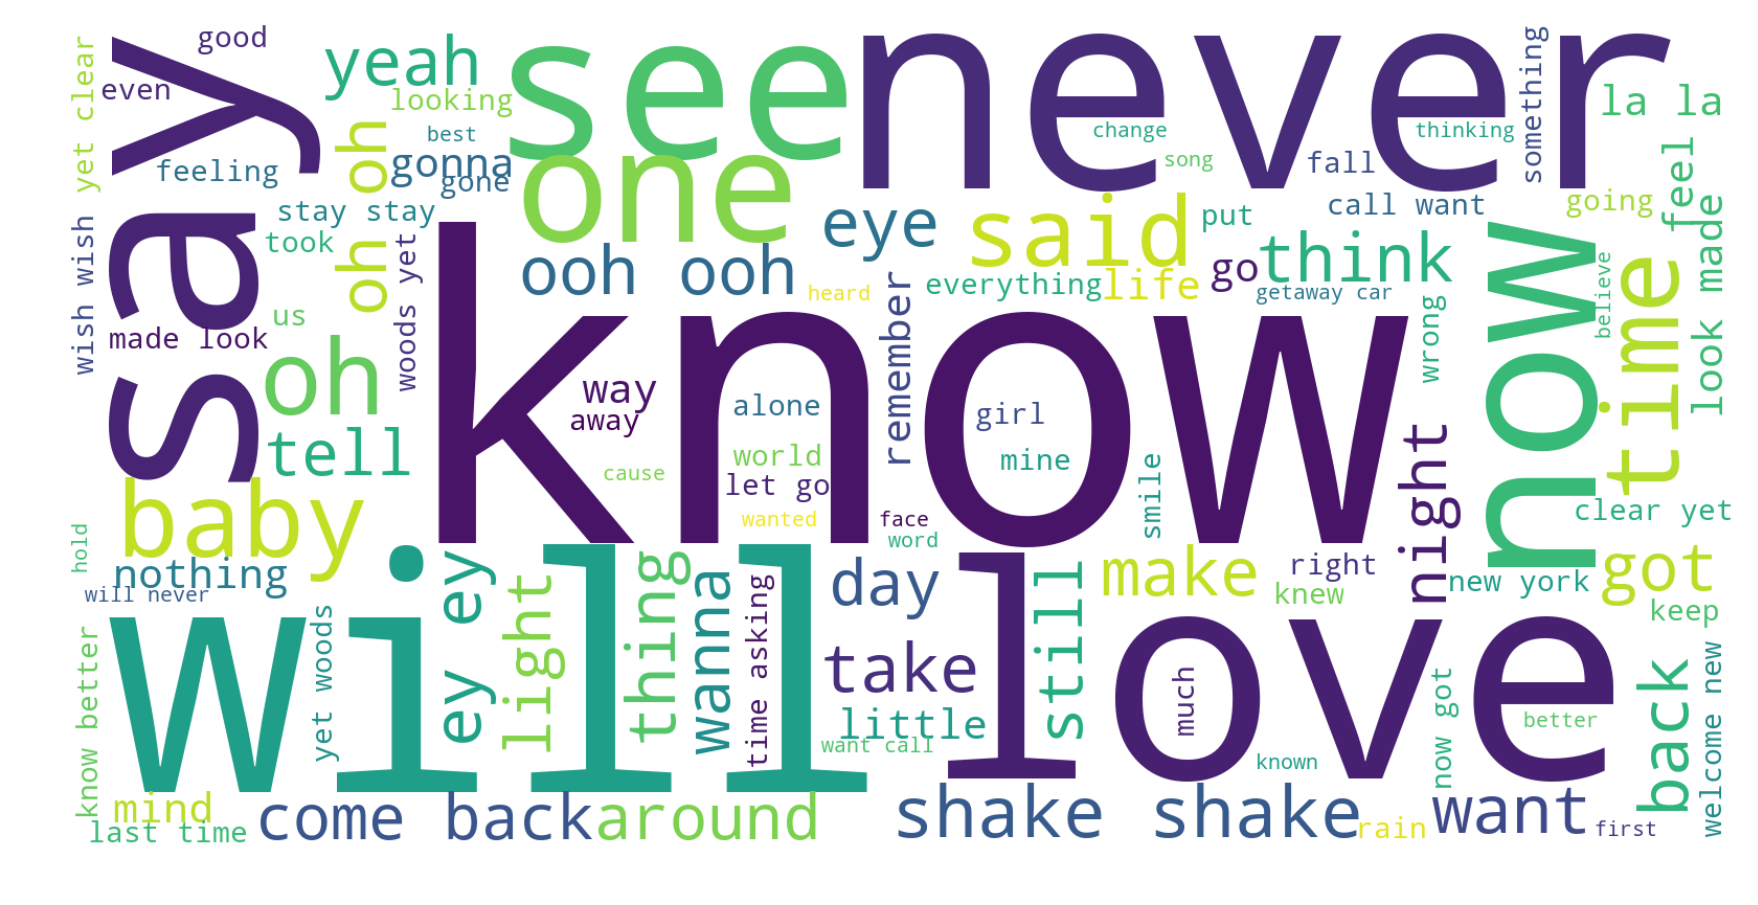

In [9]:
f = plt.figure(figsize=(15,15))
wordcloud = WordCloud(stopwords=STOPWORDS,
                      max_words=100, scale=4,
                      background_color="white").generate(songs.lyric.sum())

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
f.savefig('figs/wordcloud.png', dpi=300);

Now that we've got a clean dataset we can get on to answering our 3 questions, viz:
+ Has Taylor's songs become shorter over time?
+ Has Taylor's songs become happier over time?
+ Has Taylor's songs become more repetitive over time?

## Question 1: Song length?

To make an informed decision on whether Taylor's songs have gotten shorter over time, we will look at 2 metrics:
+ Average total words per song per album
+ Average total unique words per song per album

In [10]:
songs['num_words'] = songs.lyric.apply(lambda x: len(wordpunct_tokenize(x)))
songs['num_unique_words'] = songs.lyric.apply(lambda x: len(set(wordpunct_tokenize(x))))

Below we calculate the average number of distinct and unique words per songs for each album.

In [11]:
album_length = songs.drop(['track_n'], axis=1).\
groupby(['year', 'album']).\
mean().reset_index().rename(columns={'num_words':'avg_num_words',
                                     'num_unique_words':'avg_num_unique_words'})
album_length

,year,album,avg_num_words,avg_num_unique_words
0,2006,taylor swift,303.285714,102.357143
1,2008,fearless,358.461538,126.230769
2,2010,speak now,419.235294,139.823529
3,2012,red,354.052632,113.894737
4,2014,1989,440.125000,113.062500
5,2017,reputation,498.666667,126.066667


Below we plot the total number of words per song, the bands around each album shows the variation of song lengths within each album.

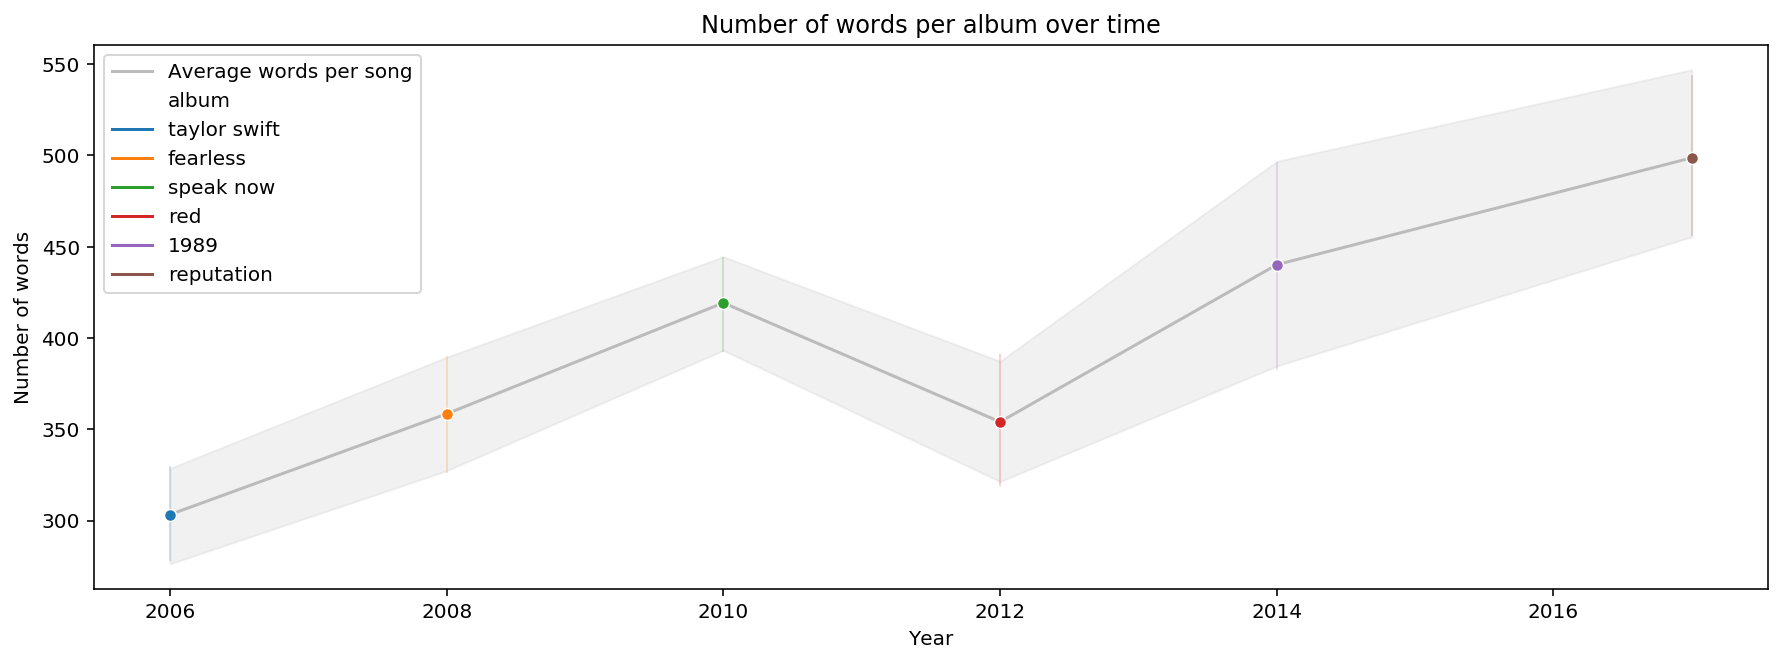

In [12]:
f = plt.figure(figsize=(15,5))
sns.lineplot(data=songs, x='year', y='num_words', label='Average words per song', color='#BBBBBB')
sns.lineplot(data=songs, x='year', y='num_words', hue='album', marker='o')
plt.title('Number of words per album over time')
plt.ylabel('Number of words')
plt.xlabel('Year')
f.savefig('figs/num_words_over_time.png', dpi=300);

Below we plot the total number of unique words per song. Again the bands around each album shows the variation of unique words for all the song within a album.

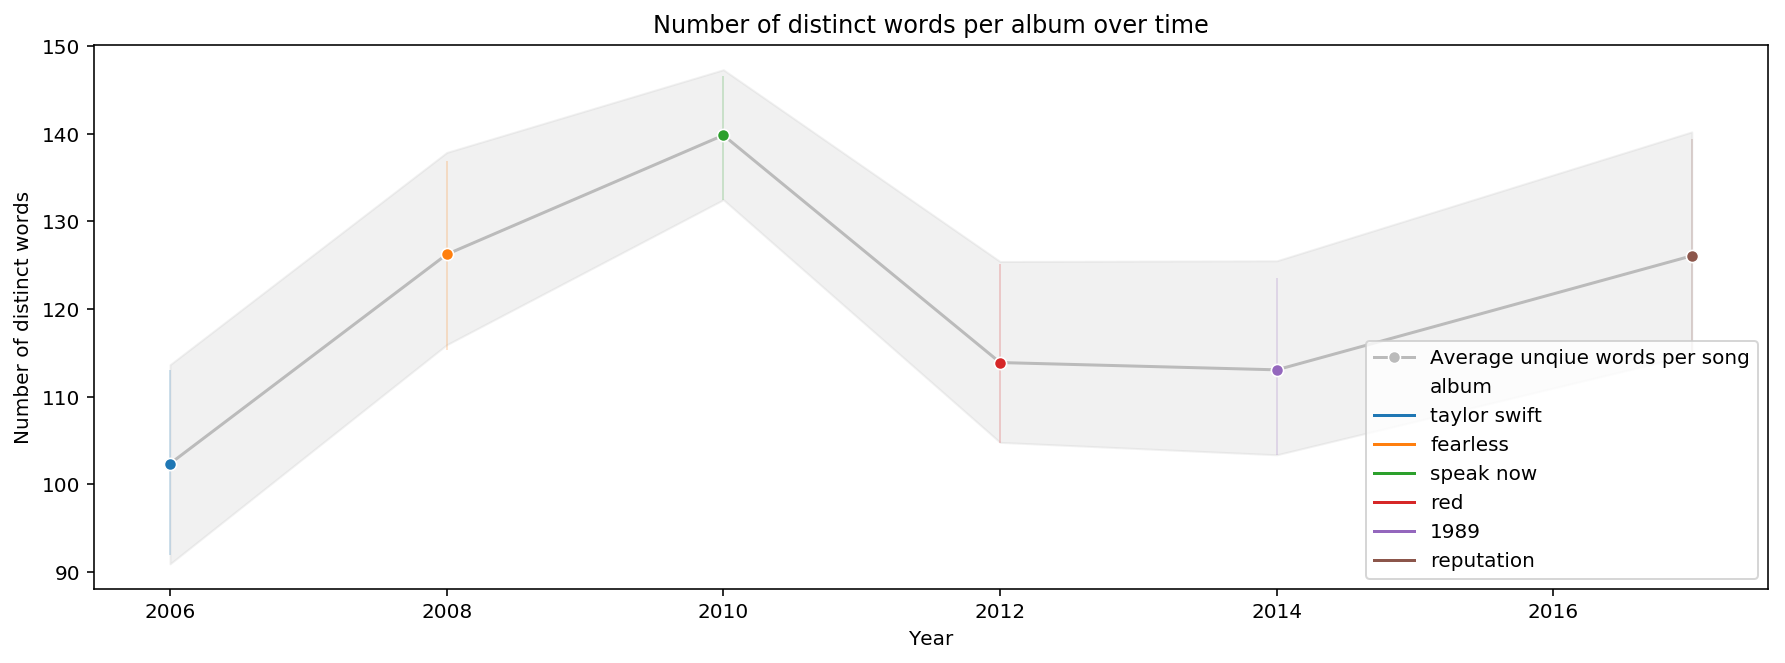

In [13]:
f = plt.figure(figsize=(15,5))
sns.lineplot(data=songs, x='year', y='num_unique_words', marker='o', label='Average unqiue words per song', color='#BBBBBB')
sns.lineplot(data=songs, x='year', y='num_unique_words', hue='album', marker='o')
plt.title('Number of distinct words per album over time')
plt.ylabel('Number of distinct words')
plt.xlabel('Year')
f.savefig('figs/num_unq_words_over_time.png', dpi=300);

From the two plots above, it appears that Taylor has been using the same number of unique words from 2006 to 2016. However, as time has progress she does appear to be using more words in her songs.

## Question 2: Happiness?

We use the Textblob.sentiment method to get a sentiment value for each song between -1 and 1, where -1 is negative and 1 is positive.

### Per Song

First we compute the sentiment per song and look at the sentiment over time.

In [14]:
songs['polarity'] = songs.lyric.apply(lambda x: TextBlob(x).sentiment.polarity)

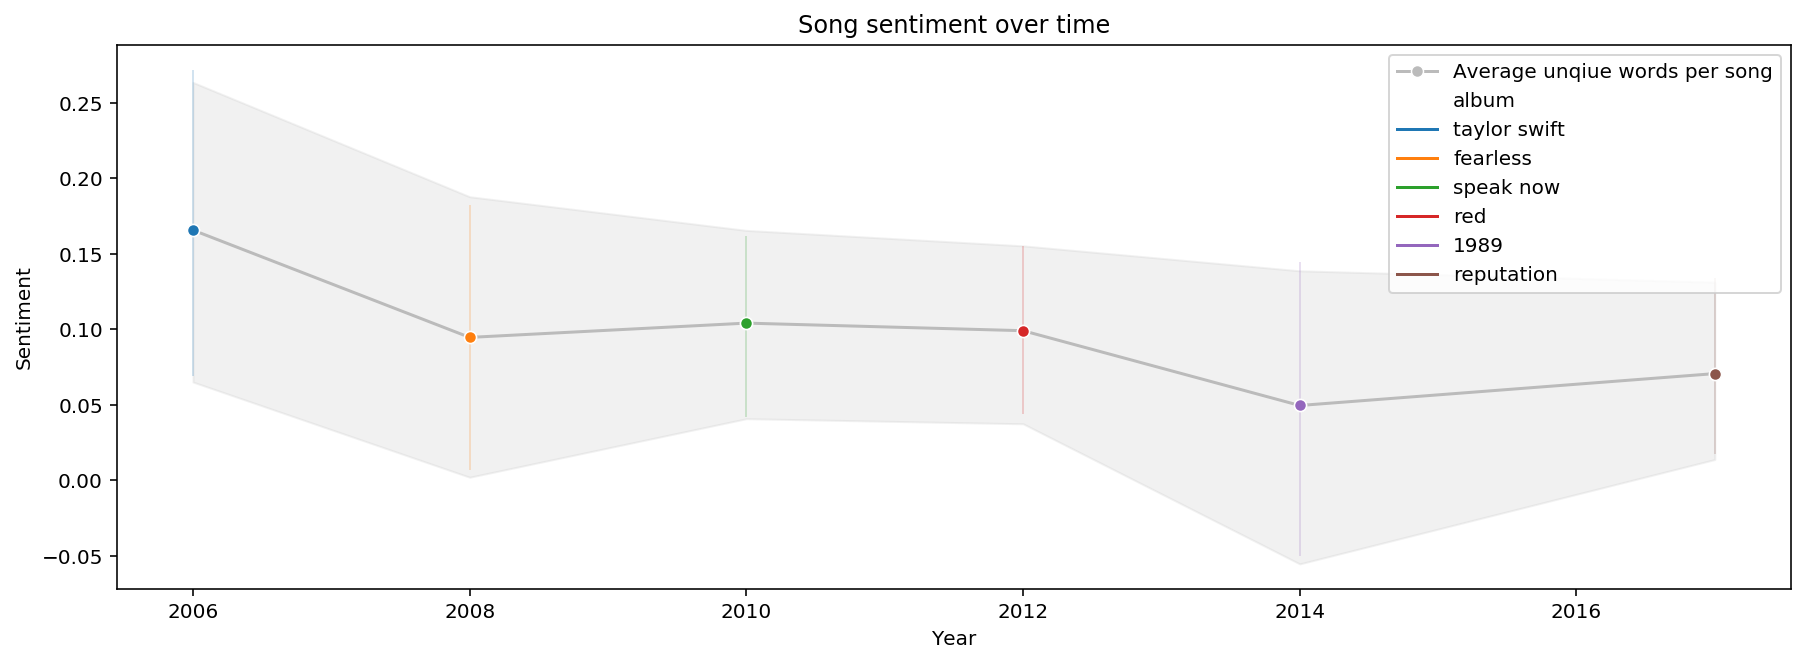

In [15]:
f = plt.figure(figsize=(15,5))
sns.lineplot(data=songs, x='year', y='polarity', marker='o', label='Average unqiue words per song', color='#BBBBBB')
sns.lineplot(data=songs, x='year', y='polarity', hue='album', marker='o')
plt.title('Song sentiment over time')
plt.ylabel('Sentiment')
plt.xlabel('Year')
f.savefig('figs/songs_sentiment_over_time.png', dpi=300);

From the above graph it does appear that Taylor's songs are getting more negative over time. However sentiment algorithm like the one used by Textblob perform better with more data and as songs are quite short, perhaps we can gain better insights into the sentiment per album if we add all the lyrics for an album together. 

### Per Album

In [16]:
albums = pd.DataFrame(songs.groupby(['year', 'album']).lyric.sum()).reset_index()
albums['polarity'] = albums.lyric.apply(lambda x: TextBlob(x).sentiment.polarity)
albums

,year,album,lyric,polarity
0,2006,taylor swift,he said the way my blue eyes shined put those ...,0.135258
1,2008,fearless,there is something about the way the street lo...,0.094324
2,2010,speak now,you were in college working parttime waiting t...,0.090480
3,2012,red,i am walking fast through the traffic lights b...,0.102127
4,2014,1989,walking through a crowd the village is aglow k...,0.070069
5,2017,reputation,knew he was a killer first time that i saw him...,0.079120


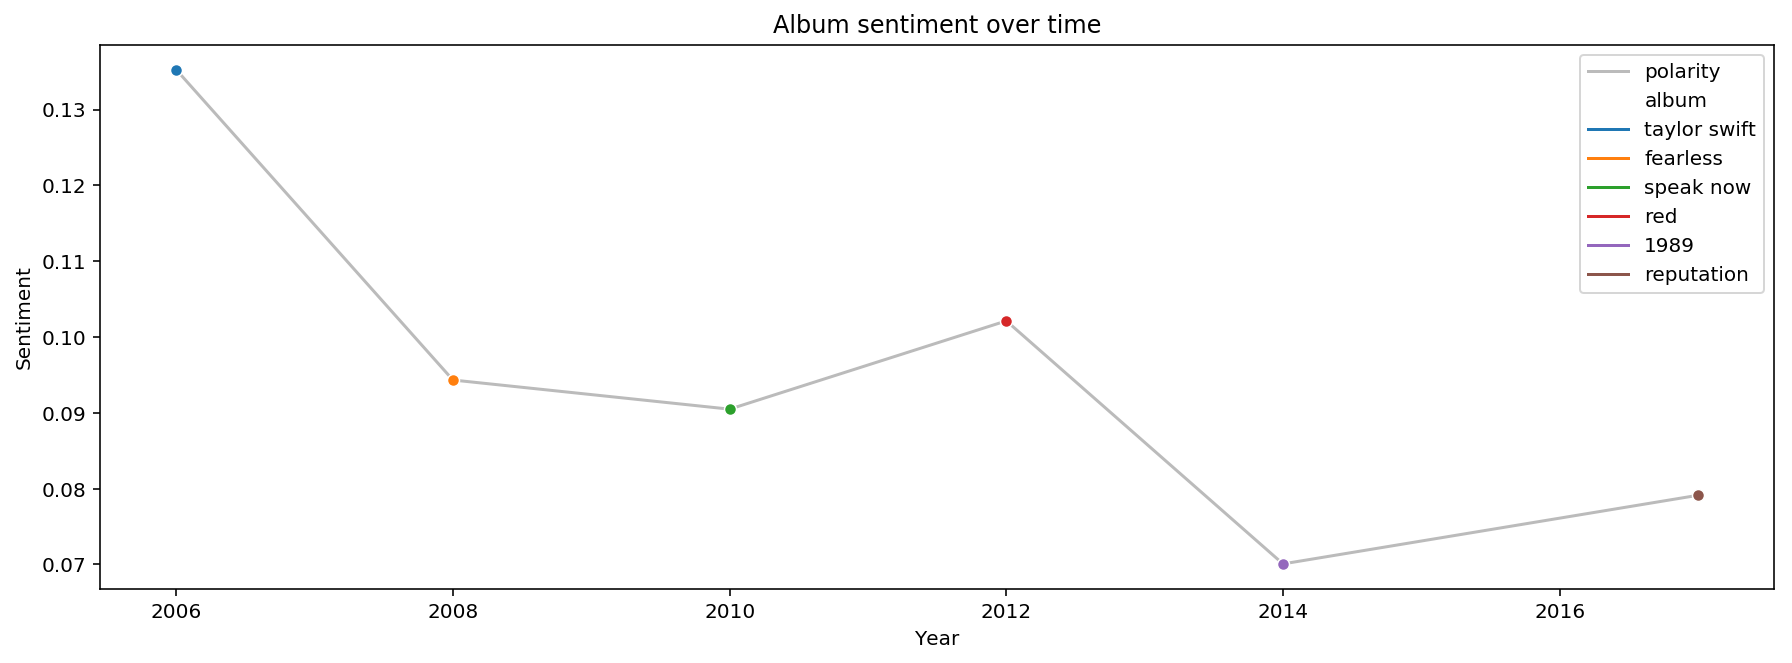

In [17]:
f = plt.figure(figsize=(15,5))
sns.lineplot(data=albums, x='year', y='polarity', label='polarity', color='#BBBBBB')
sns.lineplot(data=albums, x='year', y='polarity', hue='album', marker='o')
plt.title('Album sentiment over time')
plt.ylabel('Sentiment')
plt.xlabel('Year')
f.savefig('figs/album_sentiment_over_time.png', dpi=300);

From the above graph it is clear that the albums have gotten less positive over time.

## Question 3: Repetitiveness

### Measuring repetitiveness?

In his <a href='https://pudding.cool/2017/05/song-repetition/'>essay</a>, Colin was interested in whether pop music has gotten more repetitive over time and he looked at the lyrics in pop songs to quantify this repetitiveness. He argued that it is easy for a human to identify a repetitive song, but translating that intuition into a number isn't easy. One thing he tried was to look at the number of unique words in a song, as a fraction of the total number of words. But this metric would call the following lyric excerpts equally repetitive:

<div class="prose-pull-quote">
  <div class="row flex-box">
      <div class="col-xs-5">
          <blockquote>
          <p>baby I don't need dollar bills to have fun tonight<br>
          I love cheap thrills<br>
          baby I don't need dollar bills to have fun tonight<br>
          I love cheap thrills<br>
          I don't need no money<br>
          as long as I can feel the beat<br>
          I don't need no money<br>
          as long as I keep dancing</p>
          <p class="block-cite"><cite>~ Sia, Cheap Thrills</cite></p>
          </blockquote>
      </div>
      <div class="col-xs-5">
          <blockquote><p>tonight I need dollar bills<br>
          I don't keep fun<br>
          cheap thrills long to feel money<br>
          the bills don't need the dancing baby<br>
          fun dollar dancing thrills the baby I need<br>
          don't have fun<br>
          no no don't have dancing fun tonight<br>
          beat the can as I don't feel thrills<br>
          love the dancing money</p>
          <p class="block-cite"><cite>~ Colin Morris, Original composition</cite></p>
          </blockquote>
      </div>
  </div>
</div>
    
These are both 52 words long and use the same 23 word vocabulary, but the first one is clearly more repetitive, because it arranges words in a predictable, repetitive order.

### Repetitiveness ≈ compressibility?

You may not have heard of the Lempel-Ziv algorithm, but you probably use it every day. It's a lossless compression algorithm that powers gifs, pngs, and most archive formats (zip, gzip, rar...).

What does this have to do with pop music? The Lempel-Ziv algorithm works by exploiting repeated sequences. How efficiently LZ can compress a text is directly related to the number and length of the repeated sections in that text. 

Below we write all of our songs to text files, as well as, compressing those files. We then read back in the size in bytes that each songs takes on disk.

In [18]:
#Create the required directories
base_dir = 'song_lyrics'
plain_dir = base_dir+'/plain/'
compr_dir = base_dir+'/compressed/'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    if not os.path.exists(plain_dir):
        os.makedirs(plain_dir)
    if not os.path.exists(compr_dir):
        os.makedirs(compr_dir)

#Write both the text and gzipped file
song_ids = []
for year, track_n in zip(songs.year, songs.track_n):
    song = songs[(songs.year == year)& (songs.track_n == track_n)]
    lyrics = song.lyric.values[0]
    song_id = '%d_%d'%(year,track_n)
    song_ids.append(song_id)
    
    with open(plain_dir+song_id, 'w+') as f:
        f.write(lyrics)
    with gzip.open(compr_dir+song_id, 'wb') as f:
        f.write(bytes(lyrics, 'utf-8'))

#Read in the sizes of the files
plain_size = []
compr_size = []
for song_id in song_ids:
    plain_size.append(os.path.getsize(plain_dir+song_id))
    compr_size.append(os.path.getsize(compr_dir+song_id))

#Construct a DataFrame and join it with our original DataFrame
song_sizes = pd.DataFrame(dict(song_id = song_ids,
                 normal_bytes = plain_size,
                 compressed_bytes = compr_size))
year_track_n = song_sizes.song_id.str.split('_', expand=True).rename(columns={0:'year', 1:'track_n'})
song_sizes = pd.concat([song_sizes.drop('song_id', axis=1), year_track_n], axis=1)
song_sizes.year = song_sizes.year.astype(int)
song_sizes.track_n = song_sizes.track_n.astype(int)

songs = songs.merge(song_sizes, on=['year', 'track_n'])
songs.drop('lyric', axis=1).head()

,year,album,track_n,track_title,num_words,num_unique_words,polarity,normal_bytes,compressed_bytes
0,2006,taylor swift,1,tim mcgraw,376,119,0.105707,1781,576
1,2006,taylor swift,2,picture to burn,321,109,-0.199145,1560,483
2,2006,taylor swift,3,teardrops on my guitar,314,126,0.260434,1403,541
3,2006,taylor swift,4,a place in this world,263,81,0.216111,1071,361
4,2006,taylor swift,5,cold as you,250,100,0.247917,1178,436


Next we calculate the compression rate as:

$$compression\_rate = \left| {\frac{{compressed\_size - normal\_size}}{{normal\_size}}} \right|\times100$$

In [19]:
songs['compression_rate'] = np.abs((songs.compressed_bytes - songs.normal_bytes)/songs.normal_bytes*100)

Plotting the compression rate over time, we see that as time goes on, songs are more compressable, implying that they have indeed become more repetitive.

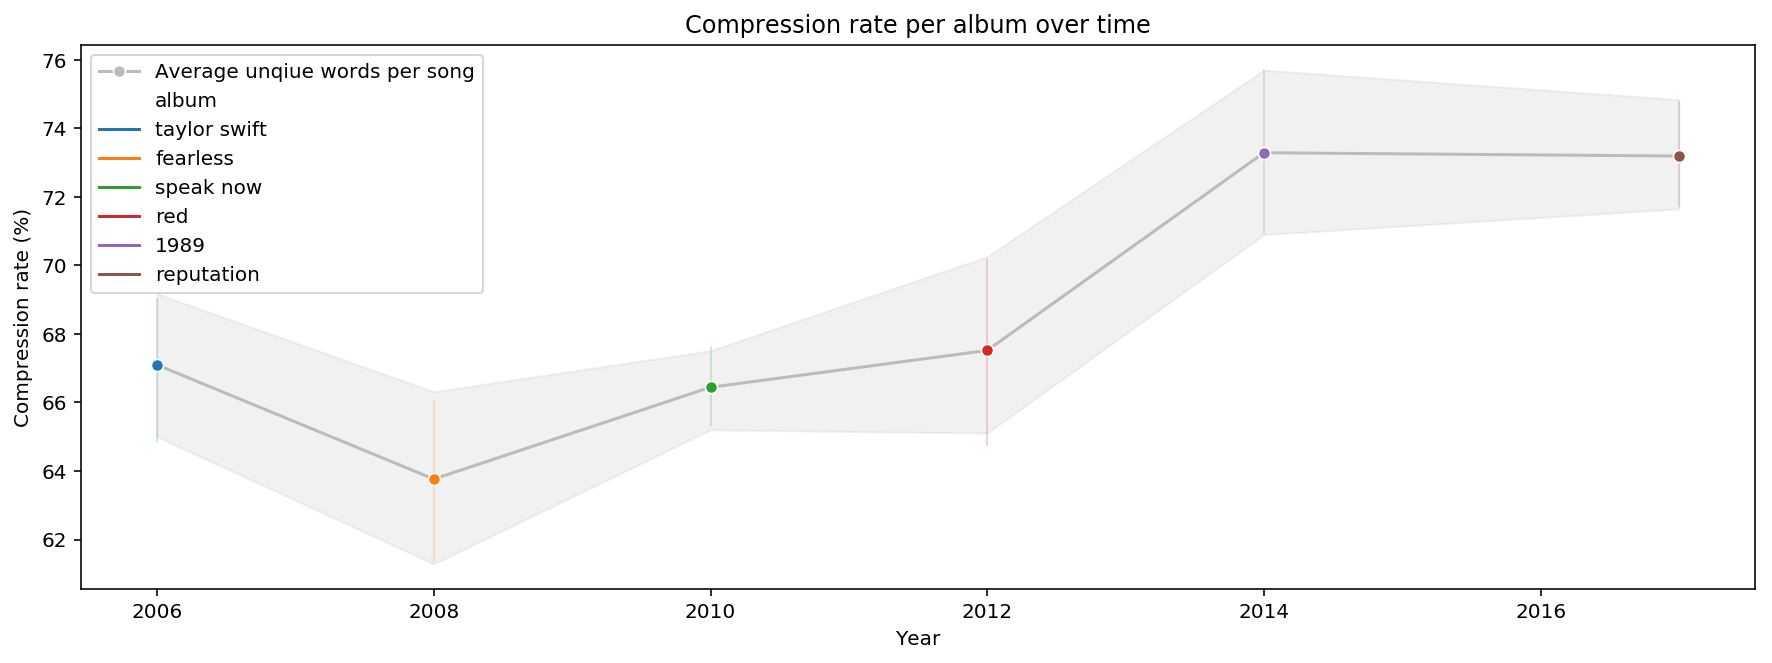

In [20]:
f = plt.figure(figsize=(15,5))
sns.lineplot(data=songs, x='year', y='compression_rate', marker='o', label='Average unqiue words per song', color='#BBBBBB')
sns.lineplot(data=songs, x='year', y='compression_rate', hue='album', marker='o')
plt.title('Compression rate per album over time')
plt.ylabel('Compression rate (%)')
plt.xlabel('Year')
f.savefig('figs/compression_over_time.png', dpi=300);

Below we look at the top 3 most compressable songs.

In [21]:
songs.sort_values(by='compression_rate').tail(3)[['year', 'album', 'track_title', 'compression_rate']]

,year,album,track_title,compression_rate
84,2017,reputation,look what you made me do,79.330709
68,2014,1989,shake it off,79.992855
66,2014,1989,out of the woods,81.617647


If we look at the lyrics for `Out of the woods` from the 2014 album `1989` we see that they do indeed repeat words quite often.

In [22]:
out_of_the_woods = songs[songs.track_title == 'out of the woods']
print("""
Out of the woods
""")
print(out_of_the_woods.lyric.values[0])


Out of the woods

looking at it now it all seems so simple we were lying on your couch i remember you took a polaroid of us then discovered then discovered the rest of the world was black and white but we were in screaming color and i remember thinking are we out of the woods yet are we out of the woods yet are we out of the woods yet are we out of the woods are we in the clear yet are we in the clear yet are we in the clear yet in the clear yet good are we out of the woods yet are we out of the woods yet are we out of the woods yet are we out of the woods are we in the clear yet are we in the clear yet are we in the clear yet in the clear yet good are we out of the woods looking at it now last december last december we were built to fall apart then fall back together back together your necklace hanging from my neck the night we could not quite forget when we decided we decided to move the furniture so we could dance baby like we stood a chance two paper airplanes flying flying flyin

The top 3 uncompressable songs on the other hand are:

In [23]:
songs.sort_values(by='compression_rate').head(3)[['year', 'album', 'track_title', 'compression_rate']]

,year,album,track_title,compression_rate
25,2008,fearless,the best day,55.615942
20,2008,fearless,breathe (ft. colbie caillat),56.832579
48,2012,red,all too well,57.910839


Looking at the lyrics for `The best day` from the 2008 album `Fearless` we see that her is a lot less repeating of words.

In [24]:
the_best_day = songs[songs.track_title == 'the best day']
print("""
The best day
""")
print(the_best_day.lyric.values[0])


The best day

i am five years old it is getting cold i have got my big coat on i hear your laugh and look up smiling at you i run and run past the pumpkin patch and the tractor rides look now the sky is gold i hug your legs and fall asleep on the way home i do not know why all the trees change in the fall but i know you are not scared of anything at all do not know if snow whites house is near or far away but i know i had the best day with you today i am thirteen now and do not know how my friends could be so mean i come home crying and you hold me tight and grab the keys and we drive and drive until we found a town far enough away and we talk and window shop until i have forgotten all their names i do not know who i am going to talk to now at school but i know i am laughing on the car ride home with you do not know how long it is going to take to feel okay but i know i had the best day with you today i have an excellent father his strength is making me stronger god smiles on my littl

## Conclusion

From our analysis we've seen that Taylor's songs have gotten more words per song over time, although not necessarily more unique words per song. Also, we've seen that her songs have become more negative over time, which we kind of expected if we look at her current public image. 

Lastly, we saw that her songs have indeed become more repetitive based on our compression rate metric. Do these  observations mean that her songs have become better or worse over time? Well, that we can't say much about as music taste is a very subjective things and depending on who you are and where you are in life you might fancy new Taylor more than old Taylor. Or you might have disliked her through all of her albums over the years. Either way, it does appear that compression algorithms have got more use in life that just compressing a file to save a bit of bandwidth.